Set up environment

In [1]:
from copy import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import pandas as pd
import seaborn as sns
sns.set_style("white")

In [2]:
import sys
sys.path.append('/Users/zeynepenkavi/Dropbox/RangelLab/NeuralMassModels/helpers')
from eGLM_model import default_args, generateStructuralNetwork, generateSynapticNetwork, networkModel
from eGLM_helpers import phi, make_stimtimes
from multregconn import multregconn
from get_pearson_fc_wci import get_pearson_fc_wci

Importing eGLM helpers...
All eGLM helpers imported!


# Make network

In [3]:
num_sims = 10
networks = np.ndarray(num_sims, dtype=object)

In [4]:
for i in range(num_sims):
    sim_args = copy(default_args)
    sim_args.update({'hubnetwork_dsity': .5,
                'outnetwork_dsity':.3, 
                'innetwork_dsity': .60,})
    W = generateSynapticNetwork(generateStructuralNetwork(sim_args))
    sim_args.update({'W': W,
                'noise': 1, 
                'noise_scale': 1,
                'Tmax': 1500})
    networks[i] = sim_args

# Generate time series

## Resting

Resting data in this case is only noise not an AR(1) process.

In [5]:
rest_data = np.ndarray(num_sims, dtype=object)

for i in range(num_sims):
    sim_args = networks[i]
    rest_data[i], _ = networkModel(sim_args['W'], args_dict=sim_args)

# Compute FC connectivity matrices

## Pearson


In [12]:
pearson_fcs = np.ndarray(num_sims, dtype=object)
pearson_fcs_lb = np.ndarray(num_sims, dtype=object)
pearson_fcs_ub = np.ndarray(num_sims, dtype=object)
pearson_fcs_rmse = np.ndarray(num_sims, dtype=object)

for i, cur_data in enumerate(rest_data):
    pearson_fcs[i], pearson_fcs_lb[i], pearson_fcs_ub[i], pearson_fcs_rmse[i] = get_pearson_fc_wci(cur_data, networks[i])

Plot distribution of rmse's

Text(0.5, 0, 'RMSE')

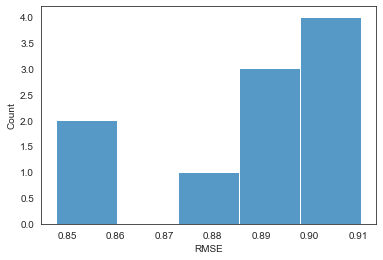

In [37]:
sns.histplot(pearson_fcs_rmse)
plt.xlabel("RMSE")

Plot predicted vs actual with CI's around predicted values for each (x=y line added in blue)

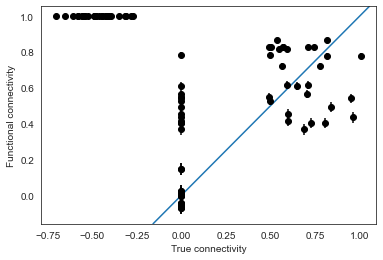

In [41]:
for i in range(num_sims):
    le = pearson_fcs[i] - pearson_fcs_lb[i]
    ue = pearson_fcs_ub[i] - pearson_fcs[i]
    plt.errorbar(x = np.ndarray.flatten(networks[i]['W']), y = np.ndarray.flatten(pearson_fcs[i]), yerr = np.array([np.ndarray.flatten(le), np.ndarray.flatten(ue)]), fmt='o', color="black")

plt.xlabel("True connectivity")
plt.ylabel("Functional connectivity")
plt.axline([0, 0], [1, 1])

## Multiple regression

FC estimated by using the [multiple regression used by Cole et al.](https://github.com/ColeLab/ActflowToolbox/blob/master/connectivity_estimation/multregconn.py) expanded to add confidence intervals and rmse [here](https://github.com/zenkavi/NeuralMassModels/blob/master/helpers/multregconn.py).

In [ ]:
mreg_fcs = np.ndarray(len(timeseries), dtype=object)
mreg_fcs_lb = np.ndarray(len(timeseries), dtype=object)
mreg_fcs_ub = np.ndarray(len(timeseries), dtype=object)
mreg_fcs_rmse = np.ndarray(len(timeseries), dtype=object)

for i, cur_data in enumerate(rest_data):
    mreg_fcs[i], mreg_fcs_lb[i], mreg_fcs_ub[i], mreg_fcs_rmse[i] = multregconn(cur_data)

In [42]:
activity_matrix = rest_data[1]
nnodes = activity_matrix.shape[0]

In [45]:

connectivity_mat = np.zeros((nnodes,nnodes))
targetnode = 1
othernodes = list(range(nnodes))
othernodes.remove(targetnode) # Remove target node from 'other nodes'
X = activity_matrix[othernodes,:].T
y = activity_matrix[targetnode,:]
#Note: LinearRegression fits intercept by default (intercept beta not included in coef_ output)
if len(othernodes)>0:
    reg = LinearRegression().fit(X, y)
    connectivity_mat[targetnode,othernodes]=reg.coef_

In [47]:
reg.coef_

array([-0.09200253,  0.37601158])

In [49]:
import statsmodels.api as sm

In [50]:
X = sm.add_constant(X)

# Fit and summarize OLS model
mod = sm.OLS(y, X)

res = mod.fit()

In [55]:
res.conf_int()[1:] #excluding CI for intercept

array([[-0.11980805, -0.06419702],
       [ 0.34752952,  0.40449364]])

In [54]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     375.8
Date:                Fri, 07 May 2021   Prob (F-statistic):          2.44e-146
Time:                        12:15:51   Log-Likelihood:                -1918.1
No. Observations:                3000   AIC:                             3842.
Df Residuals:                    2997   BIC:                             3860.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0374      0.008      4.457      0.000       0.021       0.054
x1            -0.0920      0.014     -6.488      0.000      -0.120      -0.064
x2             0.3760      0.015     25.885      0.000       0.348       0.404
==============================================================================
Omnibus:                        8.652   Durbin-Watson:                   0.453
Prob(Omnibus):                  0.013   Jarque-Bera (JB):                7.236
Skew:                          -0.043   Prob(JB):                       0.0268
Kurtosis:                       2.775   Cond. No.                         2.13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

TODO: Add lag option to connectivity computations